In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import norm


In [48]:
data_sheet = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/var_data.xlsx',sheet_name='data')

# 월별수익률로 변화시키기
monthly_returns = data_sheet.set_index('date').pct_change()

# 비중 조절(국내주식, 해외주식, 국내채권, 해외채권 순서)
weights = np.array([0.6, 0.3, 0.0667, 0.0333])

portfolio_mean = monthly_returns.mean().dot(weights)
portfolio_covariance = monthly_returns.cov()
portfolio_corr = monthly_returns.corr()
portfolio_std = np.sqrt(weights.T.dot(portfolio_covariance).dot(weights))

# 신뢰수준 %
confidence_level = 0.95

VaR = norm.ppf(1 - confidence_level, portfolio_mean, portfolio_std)

print("평균 월간 수익률", portfolio_mean)
print("자산군 간 공분산", portfolio_covariance)
print("자산군 간 상관계수", portfolio_corr)
print("포트폴리오 표준편차", portfolio_std)
print(confidence_level*100, "%신뢰수준에서","에서 Var은", VaR)

평균 월간 수익률 0.006892010057018354
자산군 간 공분산           kospi200       snp   korbond    usbond
kospi200  0.002334 -0.000003  0.000073  0.000081
snp      -0.000003  0.001972 -0.000014  0.000005
korbond   0.000073 -0.000014  0.000035  0.000049
usbond    0.000081  0.000005  0.000049  0.000138
자산군 간 상관계수           kospi200       snp   korbond    usbond
kospi200  1.000000 -0.001369  0.253274  0.143141
snp      -0.001369  1.000000 -0.051842  0.010312
korbond   0.253274 -0.051842  1.000000  0.707210
usbond    0.143141  0.010312  0.707210  1.000000
포트폴리오 표준편차 0.032026703233633186
95.0 %신뢰수준에서 에서 Var은 -0.045787228916121636


<ipython-input-49-5bf805392eb1>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=labels, y=all_returns, palette='Blues_d', ax=axs[1, 0])


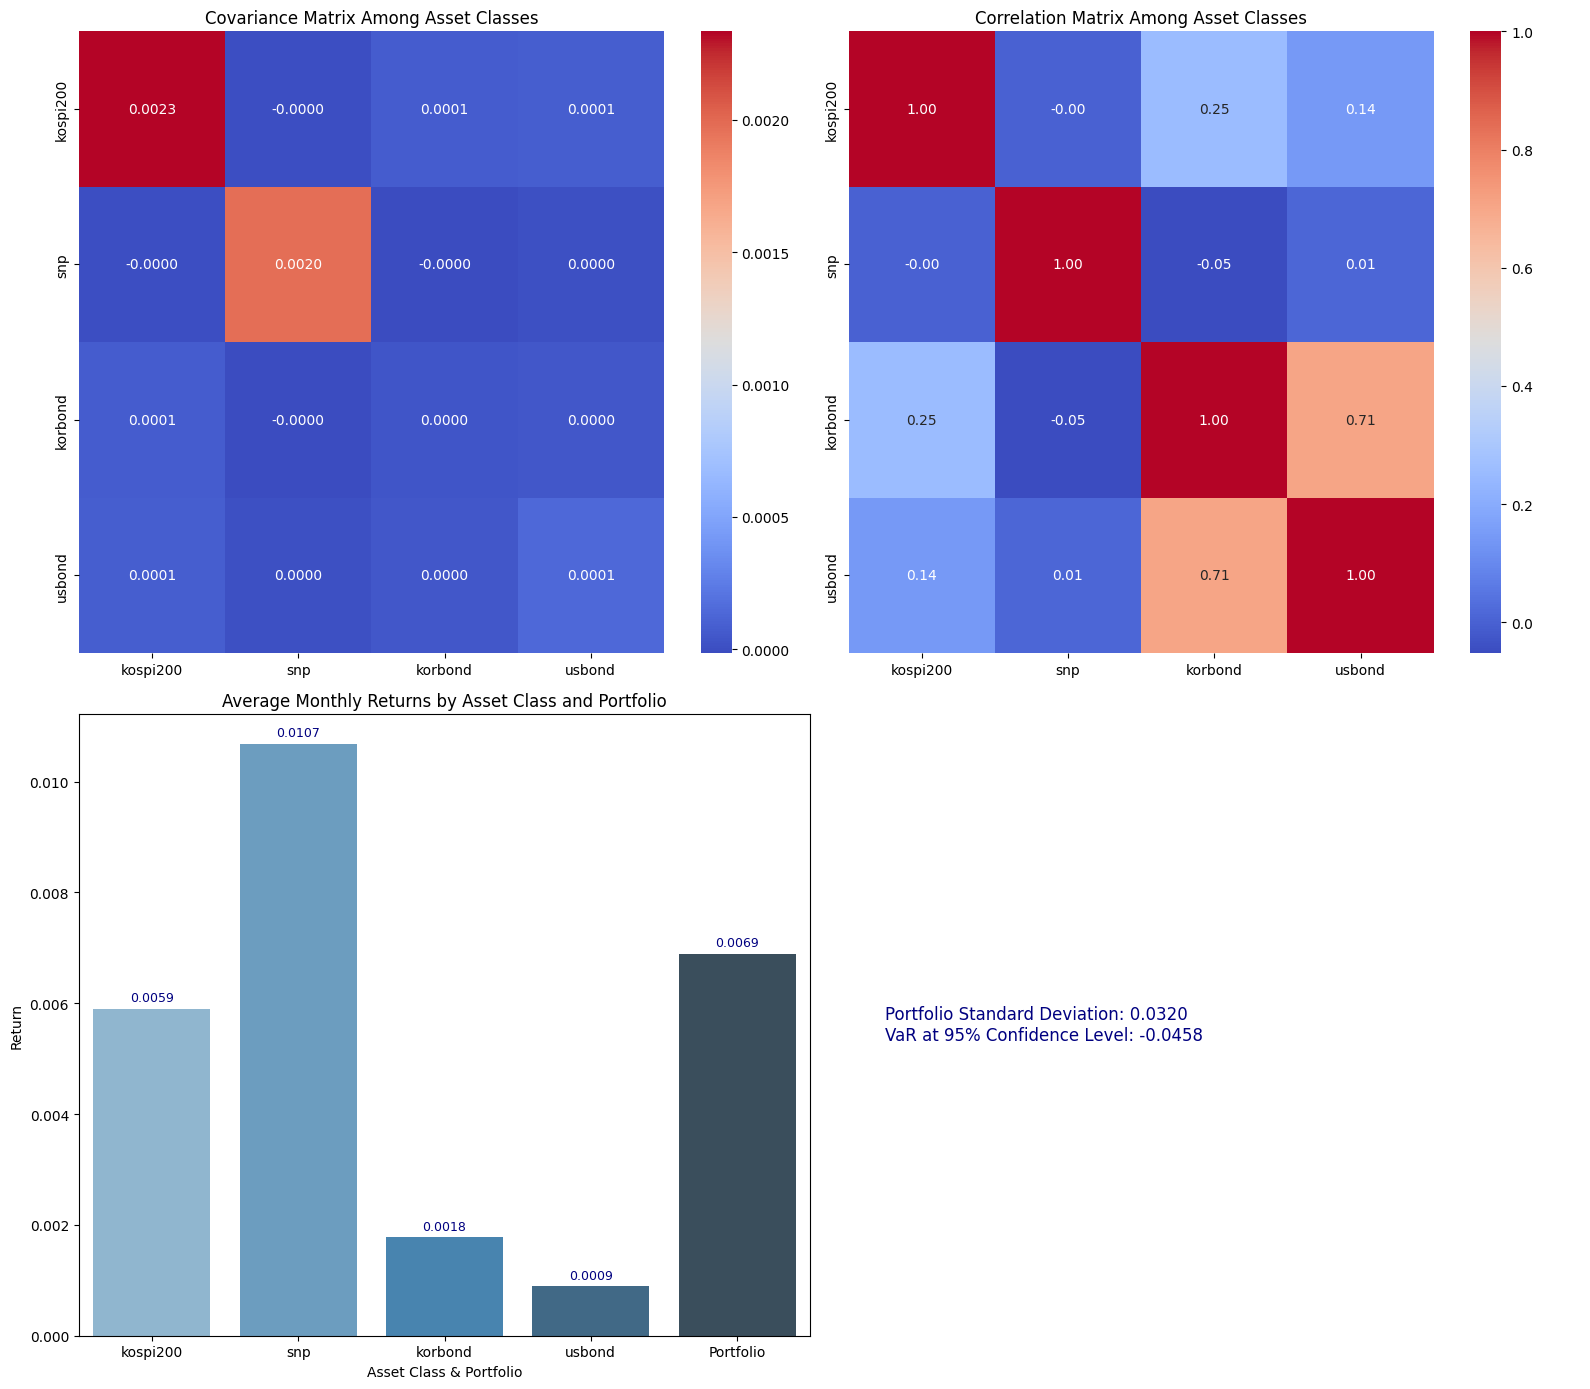

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

# Covariance Matrix Heatmap
sns.heatmap(portfolio_covariance, annot=True, fmt=".4f", cmap='coolwarm', ax=axs[0, 0])
axs[0, 0].set_title('Covariance Matrix Among Asset Classes')

# Correlation Matrix Heatmap
sns.heatmap(portfolio_corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title('Correlation Matrix Among Asset Classes')

# Visualizing the average monthly returns including the portfolio
asset_means = monthly_returns.mean().values
portfolio_return = np.array([portfolio_mean])
all_returns = np.append(asset_means, portfolio_return)
labels = list(monthly_returns.columns) + ['Portfolio']

bars = sns.barplot(x=labels, y=all_returns, palette='Blues_d', ax=axs[1, 0])
axs[1, 0].set_title('Average Monthly Returns by Asset Class and Portfolio')
axs[1, 0].set_ylabel('Return')
axs[1, 0].set_xlabel('Asset Class & Portfolio')

# Adding the text labels on each bar
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.4f'),
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='center',
                  size=9, xytext=(0, 8),
                  textcoords='offset points', color='navy')

# Increase spacing between the subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Displaying the portfolio standard deviation and VaR as text in the bottom right subplot
axs[1, 1].text(0.05, 0.5, f'Portfolio Standard Deviation: {portfolio_std:.4f}\nVaR at {int(confidence_level * 100)}% Confidence Level: {VaR:.4f}',
               fontsize=12, color='navy', va='center')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

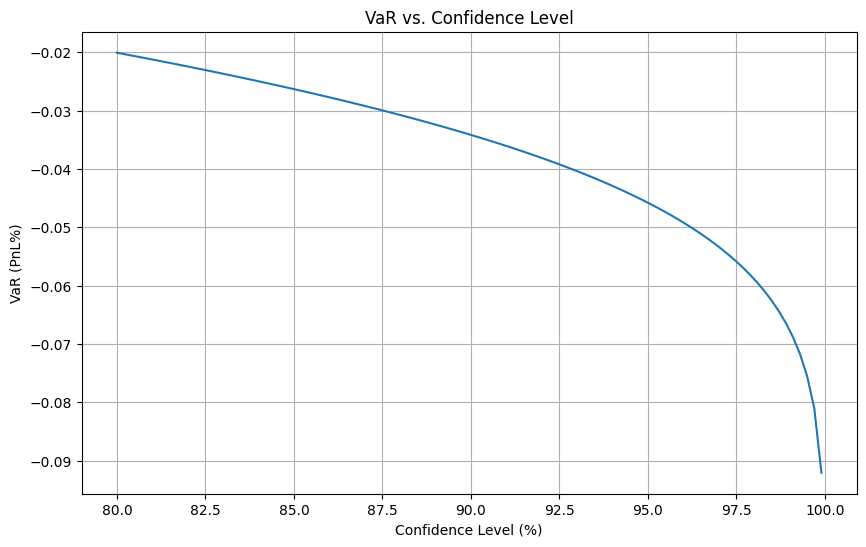

In [50]:
# Define a range of confidence levels from 90% to 99.9%
confidence_levels = np.linspace(0.8, 0.999, 100)

# Calculate VaR for each confidence level
VaRs = [norm.ppf(1 - cl, portfolio_mean, portfolio_std) for cl in confidence_levels]

# Convert confidence levels to percentage for plotting
confidence_levels_percent = confidence_levels * 100

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels_percent, VaRs, linestyle='-', markersize=5)
plt.title('VaR vs. Confidence Level')
plt.xlabel('Confidence Level (%)')
plt.ylabel('VaR (PnL%)')
plt.grid(True)
plt.show()


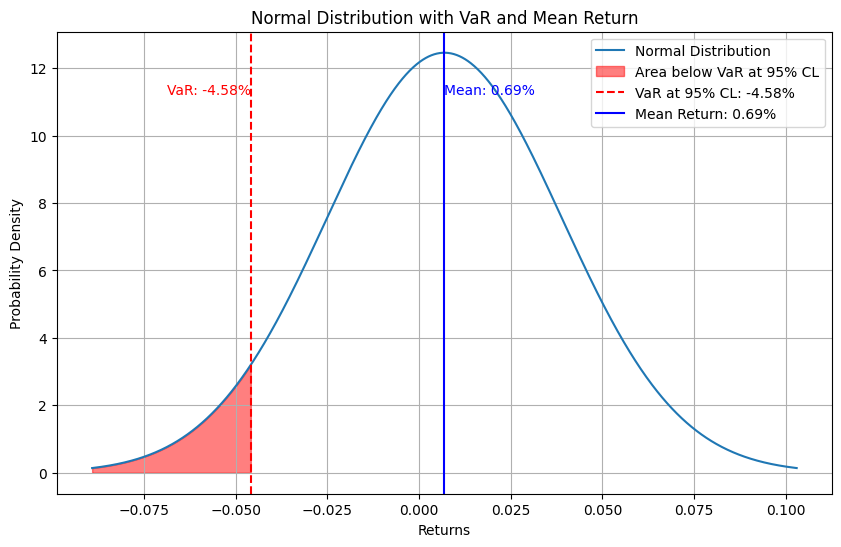

In [51]:
# Define the range for the x-axis around the mean and standard deviation
x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean + 3*portfolio_std, 1000)
y = norm.pdf(x, portfolio_mean, portfolio_std)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.fill_between(x, y, where=(x <= VaR), color='red', alpha=0.5, label=f'Area below VaR at {confidence_level*100:.0f}% CL')
plt.axvline(x=VaR, color='red', linestyle='--', label=f'VaR at {confidence_level*100:.0f}% CL: {VaR:.2%}')
plt.axvline(x=portfolio_mean, color='blue', linestyle='-', label=f'Mean Return: {portfolio_mean:.2%}')

# Adding text labels for VaR and Mean Return
plt.text(VaR, max(y) * 0.9, f'VaR: {VaR:.2%}', horizontalalignment='right', color='red')
plt.text(portfolio_mean, max(y) * 0.9, f'Mean: {portfolio_mean:.2%}', horizontalalignment='left', color='blue')

plt.title('Normal Distribution with VaR and Mean Return')
plt.xlabel('Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


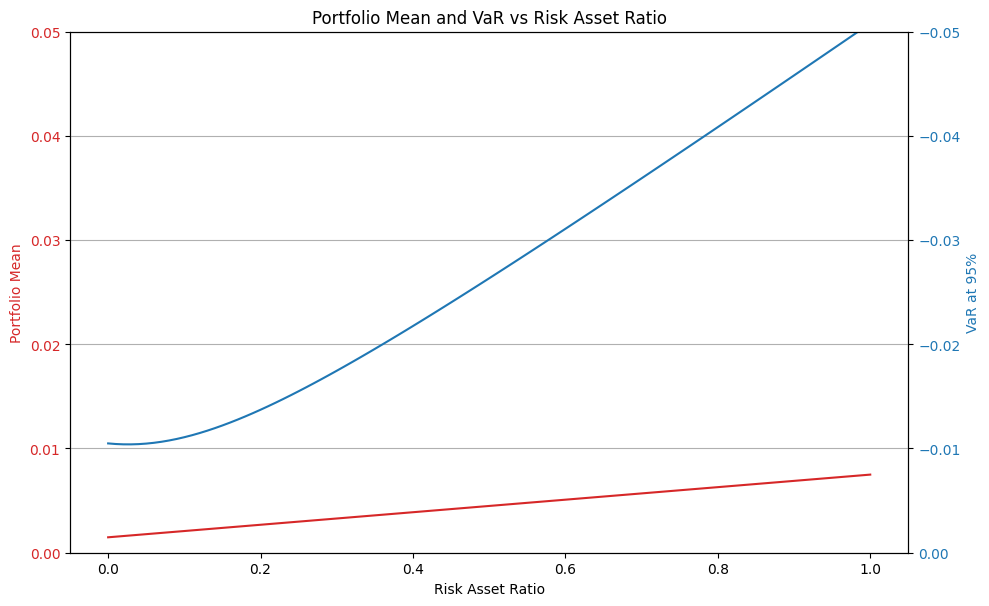

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 데이터 로딩
data_sheet = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/var_data.xlsx', sheet_name='data')
monthly_returns = data_sheet.set_index('date').pct_change()

# 신뢰수준
confidence_level = 0.95

# 비중 조정 및 VaR 계산
risk_asset_ratios = np.arange(0, 1.01, 0.01)  # 0%에서 100%까지 1% 단위로 조정

# 결과를 저장할 데이터프레임
results = pd.DataFrame(columns=['Risk Asset Ratio', 'Portfolio Mean', 'Portfolio Std', 'VaR at 95%'])

for ratio in risk_asset_ratios:
    # 위험자산과 안전자산의 비중 계산
    risk_weight = ratio
    safe_weight = 1 - ratio

    # 각 자산별 비중 (위험자산:국내주식 2, 해외주식 1, 안전자산:국내채권 2, 해외채권 1)
    weights = np.array([2*risk_weight/3, 1*risk_weight/3, 2*safe_weight/3, 1*safe_weight/3])

    # 포트폴리오 평균, 공분산, 표준편차 및 VaR 계산
    portfolio_mean = monthly_returns.mean().dot(weights)
    portfolio_covariance = monthly_returns.cov()
    portfolio_std = np.sqrt(weights.T.dot(portfolio_covariance).dot(weights))
    VaR = norm.ppf(1 - confidence_level, portfolio_mean, portfolio_std)

    # 결과를 데이터프레임에 추가
    results = pd.concat([results, pd.DataFrame({
        'Risk Asset Ratio': [ratio],
        'Portfolio Mean': [portfolio_mean],
        'Portfolio Std': [portfolio_std],
        'VaR at 95%': [VaR]
    })], ignore_index=True)

# 결과 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Risk Asset Ratio')
ax1.set_ylabel('Portfolio Mean', color=color)
ax1.plot(results['Risk Asset Ratio'], results['Portfolio Mean'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.05)  # 왼쪽 y축 범위 설정

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('VaR at 95%', color=color)
ax2.plot(results['Risk Asset Ratio'], results['VaR at 95%'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, -0.05)  # 오른쪽 y축 범위 설정

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Portfolio Mean and VaR vs Risk Asset Ratio')
plt.grid(True)
plt.show()


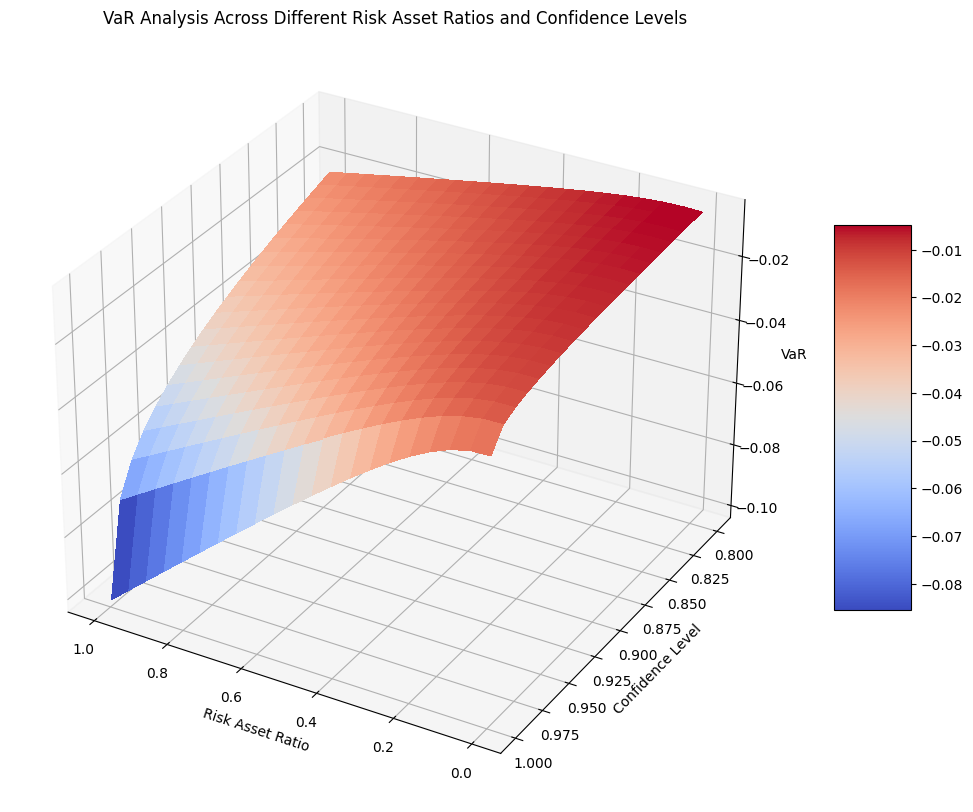

In [65]:

data_sheet = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/var_data.xlsx', sheet_name='data')
monthly_returns = data_sheet.set_index('date').pct_change()

# 위험자산 비중 및 신뢰수준 범위 설정
risk_asset_ratios = np.linspace(0, 1, 21)  # 0%에서 100%까지 5% 단위로
confidence_levels = np.linspace(0.8, 0.999, 20)  # 80%에서 99.9%까지

# 3D 데이터 배열
X, Y = np.meshgrid(risk_asset_ratios, confidence_levels)
Z = np.zeros_like(X)

# 각 조합에 대한 VaR 계산
for i in range(len(confidence_levels)):
    for j in range(len(risk_asset_ratios)):
        risk_weight = X[i, j]
        safe_weight = 1 - risk_weight
        weights = np.array([2*risk_weight/3, 1*risk_weight/3, 2*safe_weight/3, 1*safe_weight/3])

        portfolio_mean = monthly_returns.mean().dot(weights)
        portfolio_covariance = monthly_returns.cov()
        portfolio_std = np.sqrt(weights.T.dot(portfolio_covariance).dot(weights))
        Z[i, j] = norm.ppf(1 - Y[i, j], portfolio_mean, portfolio_std)

# 시각화
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Risk Asset Ratio')
ax.set_ylabel('Confidence Level')
ax.set_zlabel('VaR')
ax.set_title('VaR Analysis Across Different Risk Asset Ratios and Confidence Levels')
fig.colorbar(surf, shrink=0.5, aspect=5)

# 시점 변경
ax.view_init(elev=30, azim=120)  # 변경할 각도

plt.show()
